In [ ]:
import numba
import numpy as np
from numba import cuda, float32, int32

SM_SIZE = 1024

@cuda.jit
def prefix_sum_without_sum(arr, out):
  n = SM_SIZE
  temp = cuda.shared.array(shape=(SM_SIZE), dtype=int32)
  thid = cuda.threadIdx.x
  offset = 1

  block_id = cuda.blockIdx.x
  data_offset = block_id * cuda.blockDim.x * 2

  temp[2 * thid] = arr[data_offset + 2 * thid]
  temp[2 * thid + 1] = arr[data_offset + 2 * thid + 1]
  d = n >> 1
  while d > 0:
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      temp[bi] += temp[ai]
    offset *= 2
    d >>= 1
  cuda.syncthreads()

  if thid == 0:
    temp[n - 1] = 0
  
  d = 1
  while d < n:
    offset >>= 1
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      t = temp[ai]
      temp[ai] = temp[bi]
      temp[bi] += t
    d *= 2
  cuda.syncthreads()

  out[data_offset + 2 * thid] = temp[2 * thid]
  out[data_offset + 2 * thid + 1] = temp[2 * thid + 1]





@cuda.jit
def prefix_sum_with_sum(arr, out, sum):
  n = SM_SIZE
  temp = cuda.shared.array(shape=(SM_SIZE), dtype=int32)
  thid = cuda.threadIdx.x
  offset = 1

  block_id = cuda.blockIdx.x
  data_offset = block_id * cuda.blockDim.x * 2

  temp[2 * thid] = arr[data_offset + 2 * thid]
  temp[2 * thid + 1] = arr[data_offset + 2 * thid + 1]
  d = n >> 1
  while d > 0:
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      temp[bi] += temp[ai]
    offset *= 2
    d >>= 1
  cuda.syncthreads()

  if thid == 0:
    sum[block_id] = temp[n - 1]
    temp[n - 1] = 0
  
  d = 1
  while d < n:
    offset >>= 1
    cuda.syncthreads()
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      t = temp[ai]
      temp[ai] = temp[bi]
      temp[bi] += t
    d *= 2
  cuda.syncthreads()

  out[data_offset + 2 * thid] = temp[2 * thid]
  out[data_offset + 2 * thid + 1] = temp[2 * thid + 1]


@cuda.jit
def prefix_sum_add_sum(d_out, d_sum):
  i = cuda.grid(1)
  d_out[i] += d_sum[i // SM_SIZE]


#! note if prefix_sum_add_sum used SM_SIZE // 2 threads you use SM_SIZE = 2048
"""
SM_SIZE = 1024
max number of threads used = SM_SIZE // 2
max number of blocks used = size(d_in) // SM_SIZE
d_in, d_out max size is SM_SIZE * SM_SIZE * SM_SIZE and must be multiple of SM_SIZE
d_sum_1, d_out_2 must be of size SM_SIZE * SM_SIZE
d_out_3 must be of size SM_SIZE
details: https://developer.nvidia.com/gpugems/gpugems3/part-vi-gpu-computing/chapter-39-parallel-prefix-sum-scan-cuda
"""
def gpu_prefix_sum(d_in, d_out, d_sum_1, d_out_2, d_sum_2, d_out_3):
  nb_threads = SM_SIZE // 2
  size = d_in.shape[0]
  if d_in.shape[0] <= SM_SIZE * SM_SIZE:
    prefix_sum_with_sum[size // SM_SIZE, nb_threads](d_in, d_out, d_sum_1)
    cuda.synchronize()
    prefix_sum_without_sum[1, nb_threads](d_sum_1, d_out_2)
    cuda.synchronize()
    prefix_sum_add_sum[2 * size // SM_SIZE, nb_threads](d_out, d_out_2)
  else:
    prefix_sum_with_sum[size // SM_SIZE, nb_threads](d_in, d_out, d_sum_1)
    cuda.synchronize()
    prefix_sum_with_sum[SM_SIZE, nb_threads](d_sum_1, d_out_2, d_sum_2)
    cuda.synchronize()
    prefix_sum_without_sum[1, nb_threads](d_sum_2, d_out_3)
    cuda.synchronize()
    prefix_sum_add_sum[2 * SM_SIZE, nb_threads](d_out_2, d_out_3)
    cuda.synchronize()
    prefix_sum_add_sum[2  * size // SM_SIZE, nb_threads](d_out, d_out_2)
  cuda.synchronize()

In [ ]:
size = 1024*1024

d_arr = cuda.to_device(np.ones(size, dtype=int))
d_out = cuda.to_device(np.zeros(size, dtype=int))
d_sum_1 = cuda.device_array(shape=(SM_SIZE * SM_SIZE), dtype=np.int32)
d_out_2 = cuda.device_array(shape=(SM_SIZE * SM_SIZE), dtype=np.int32)
d_sum_2 = cuda.device_array(shape=(SM_SIZE), dtype=np.int32)
d_out_3 = cuda.device_array(shape=(SM_SIZE), dtype=np.int32)

gpu_prefix_sum(d_arr, d_out, d_sum_1, d_out_2, d_sum_2, d_out_3)
print(d_out.copy_to_host())

In [ ]:
a = np.concatenate((np.arange(1), np.ones(size - 1)))
b = np.cumsum(a.astype(int))

np.testing.assert_equal(b, d_out.copy_to_host())

In [ ]:
%timeit gpu_prefix_sum(d_arr, d_out, d_sum_1, d_out_2, d_sum_2, d_out_3)

In [ ]:
n = SM_SIZE
size = n * 1024
nb_threads = n // 2
nb_blocks = size // n

d_arr = cuda.to_device(np.ones(size))
d_out = cuda.to_device(np.zeros(size))
size_d_sum = nb_blocks // n + n * int(nb_blocks % n != 0) #1
d_sum = cuda.to_device(np.zeros(size_d_sum))

prefix_sum_with_sum[nb_blocks, nb_threads](d_arr, d_out, d_sum)
print(d_out.copy_to_host().astype(int))
print(d_sum.copy_to_host().astype(int))
print(d_arr.copy_to_host().astype(int))

d_incr = cuda.device_array(shape=(size_d_sum), dtype=np.float32)

nb = nb_blocks // n + int(nb_blocks % n != 0)
prefix_sum_without_sum[nb, nb_threads](d_sum, d_incr)
print(d_incr.copy_to_host().astype(int))

print("-------------------- ADD INCR ----------------------")
prefix_sum_add_sum[size // SM_SIZE, SM_SIZE](d_out, d_incr)
print(d_out.copy_to_host().astype(int))

In [ ]:
n = SM_SIZE
size = n * 33
nb_threads = n // 2
nb_blocks = size // n

d_arr = cuda.to_device(np.ones(size))
d_out = cuda.to_device(np.zeros(size))
size_d_sum = nb_blocks // n + n * int(nb_blocks % n != 0) #1
d_sum = cuda.to_device(np.zeros(size_d_sum))

prefix_sum_with_sum[nb_blocks, nb_threads](d_arr, d_out, d_sum)
print(d_out.copy_to_host().astype(int))
print(d_sum.copy_to_host().astype(int))
print(d_arr.copy_to_host().astype(int))

d_incr = cuda.device_array(shape=(size_d_sum), dtype=np.float32)

nb = nb_blocks // n + int(nb_blocks % n != 0)
prefix_sum_without_sum[nb, nb_threads](d_sum, d_incr)
print(d_incr.copy_to_host().astype(int))

print("-------------------- ADD INCR ----------------------")
prefix_sum_add_sum[size // SM_SIZE, SM_SIZE](d_out, d_incr)
print(d_out.copy_to_host().astype(int))

In [ ]:
import numba
import numpy as np
from numba import cuda, float32



def prefix_sum(arr, out, n):
  temp = np.zeros(128)
  thid = 63
  offset = 1

  data_offset = 0
  temp[2 * thid] = arr[data_offset + 2 * thid]
  temp[2 * thid + 1] = arr[data_offset + 2 * thid + 1]
  d = n >> 1
  while d > 0:
    
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      temp[bi] += temp[ai]
    offset *= 2
    d >>= 1


  if thid == 0:
    temp[n - 1] = 0
  
  d = 1
  while d < n:
    offset >>= 1
 
    if thid < d:
      ai = offset * (2 * thid + 1) - 1
      bi = offset * (2 * thid + 2) - 1
      t = temp[ai]
      temp[ai] = temp[bi]
      temp[bi] += t
    d *= 2


  out[data_offset + 2 * thid] = temp[2 * thid]
  out[data_offset + 2 * thid + 1] = temp[2 * thid + 1]

prefix_sum(host_arr, np.zeros(128), 128)

In [ ]:
@cuda.jit
def get_test(out):
  temp = cuda.shared.array(shape=(2048), dtype=float32)
  i = cuda.grid(1)
  temp[i % 1024] = i
  cuda.syncthreads()
  out[i % 1024] = temp[i % 1024]

test_out = cuda.device_array(shape=(1024), dtype=np.float32)
get_test[1024 * 1024, 1024](test_out)
print(test_out.copy_to_host().astype(int))

[15376]
15375
[   96    97    98 ... 15033 15034 15035]
(15376,)


/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 124 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


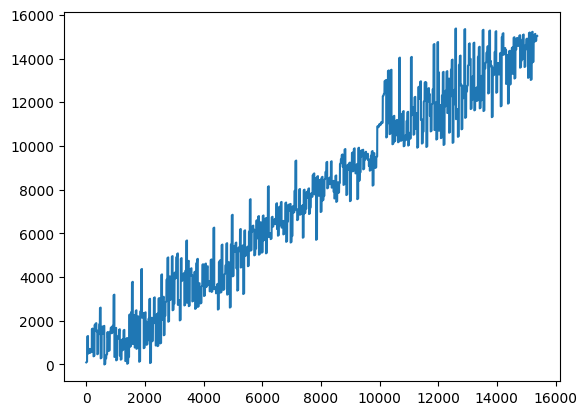

In [17]:
import numba
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def test_atomic(arr, map_arr):
  i = cuda.grid(1)
  c = cuda.atomic.add(arr, 0, 1)
  map_arr[c] = c

nb_threads = 124
nb_blocks = 124
host_map_arr = np.zeros(nb_threads * nb_blocks)
host_arr = np.array([0], dtype=int)

d_arr = cuda.to_device(host_arr)
d_map_arr = cuda.to_device(host_map_arr)

test_atomic[nb_blocks, nb_threads](d_arr, d_map_arr)

np.set_printoptions(threshold=200)
print(d_arr.copy_to_host()) #expected result should be [124*1024]
res = d_map_arr.copy_to_host().astype(int)
print(max(res)) # expected result should be [1, 2, 3, 4, 5, ....]
print(res) # expected result should be [1, 2, 3, 4, 5, ....]
print(res.shape)
plt.plot(res)



[    0     1     2 ... 15373 15374 15375]


/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 124 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


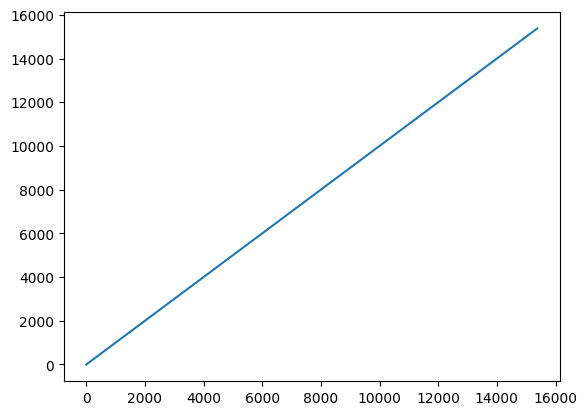

In [4]:
import numba
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def test_atomic(arr, map_arr):
  i = cuda.grid(1)
  c = cuda.atomic.add(arr, 0, 1)
  map_arr[c] = c


nb_threads = 124
nb_blocks = 124
host_map_arr = np.zeros(nb_threads * nb_blocks)
host_arr = np.array([0], dtype=int)

#device arrays
d_arr = cuda.to_device(host_arr)
d_map_arr = cuda.to_device(host_map_arr)

#run the kernel
test_atomic[nb_blocks, nb_threads](d_arr, d_map_arr)

#result
res = d_map_arr.copy_to_host().astype(int)
print(res)
plt.plot(res)



In [4]:
import numba
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def test_atomic(arr, out_1, out_2, out_3):
  i = cuda.grid(1)
  c = cuda.atomic.add(arr, 0, 1)
  out_1[c] = i * 1
  out_2[c] = i * 2
  out_3[c] = i * 3


host_arr = np.array([0], dtype=int)
d_arr = cuda.to_device(host_arr)

nb_threads = 1024
nb_blocks = 10240
host_out_1 = np.zeros(nb_threads * nb_blocks)
host_out_2 = np.zeros(nb_threads * nb_blocks)
host_out_3 = np.zeros(nb_threads * nb_blocks)

d_out_1 = cuda.to_device(host_out_1)
d_out_2 = cuda.to_device(host_out_2)
d_out_3 = cuda.to_device(host_out_3)

#run the kernel
d = cuda.device_array_like(d_out_3)
test_atomic[nb_blocks, nb_threads](d_arr, d_out_1, d_out_2, d_out_3)